In [1]:
# import statements
import numpy as np
import dicom
import cv2 
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.misc as misc
import sys
import os
sys.path.append("..")
from AlgoEngine.utils import getIsodose, getImageBlock

## Inputs to Function

In [2]:
base = '/home/radiation/RadiationTherapyDecisionSupport/data/'
StudyID = 'UCLA_PR_5'
structureset = dicom.read_file(base + StudyID + '/structureset.dcm')

In [3]:
dose_data = dicom.read_file(base + StudyID + "/dose.dcm")
dose_grid = np.array(dose_data.pixel_array)

x_spacing = np.array(dose_data.PixelSpacing[0]).astype(np.uint8)
y_spacing = np.array(dose_data.PixelSpacing[1]).astype(np.uint8)

In [4]:
dose_z = float(dose_data.ImagePositionPatient[2])
ctFilenames = [fl for fl in os.listdir(base + StudyID) if 'CT.' in fl]
ct_coords = None

for fl in ctFilenames:
    ct_struct = dicom.read_file(base + StudyID + '/' + fl)
    if(float(ct_struct.ImagePositionPatient[2]) == dose_z):
        ct_coords = ct_struct.ImagePositionPatient
        ct_spacing = ct_struct.PixelSpacing

In [5]:
x0 = float(dose_data.ImagePositionPatient[0])- float(ct_coords[0])
x0 = int(round(x0 / float(ct_spacing[0])))
y0 = float(dose_data.ImagePositionPatient[1])- float(ct_coords[1])
y0 = int(round(y0 / float(ct_spacing[1])))

DoseGridScaling = dose_data.DoseGridScaling

In [6]:
imageBlock, sopUID = getImageBlock(StudyID, base)

## Function

In [7]:
isodose = getIsodose(dose_grid, DoseGridScaling, x0, y0, x_spacing, y_spacing, sopUID)

## Testing Function

We display a single image's contours in black and white, and check that all SOP IDs have been effectively copied, and that each SOP ID in the isodose dictionary has all 7 isodose values in it


NOTE: Currently plotting overlay between Isodose and CT scan does not work- Isodose scale has not been fixed to match that of the CT scan.

In [8]:
print(len(list(isodose.keys())) == len(list(sopUID.keys())))

True


In [9]:
all_copied = True

for idx in list(sopUID.values()):
    if len(isodose[idx].keys()) < 7:
        all_copied = False

print(all_copied)

True


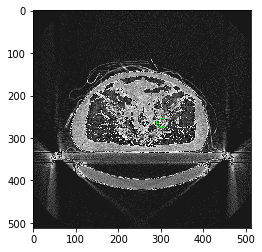

In [10]:
index = 0
showed = False
while not showed:
    image = np.repeat(np.expand_dims(imageBlock[:, :, index].astype(np.uint8), axis=2), 3, axis=2)
    sopIDs = list(sopUID.values())
    rc = isodose[sopIDs[index]]
    if rc[40].shape[0] > 0:
        for key in rc.keys():
            coords = rc[key]
            for coor in range(0, coords.shape[0]):
                x = coords[coor, 0]
                y = coords[coor, 1]
                image[x, y, :] = (0, 255, 0)
        
        showed = True
    index += 1

plt.imshow(image)
plt.show()
    